In [4]:
!nvidia-smi

Mon Oct 10 01:52:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import gc
import re
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
from IPython import display as ipd
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import random
from joblib import Parallel, delayed

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.model_selection import StratifiedGroupKFold

from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import plot_importance


import missingno as msno
import plotly.express as px

# Keras
import tensorflow as tf

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import glob

path = '/content/drive/MyDrive/data/Aerial_Cactus_Identification/'

files = glob.glob(path + '*')
files

['/content/drive/MyDrive/data/Aerial_Cactus_Identification/sample_submission.csv',
 '/content/drive/MyDrive/data/Aerial_Cactus_Identification/train.csv',
 '/content/drive/MyDrive/data/Aerial_Cactus_Identification/test',
 '/content/drive/MyDrive/data/Aerial_Cactus_Identification/train']

In [7]:
labels = pd.read_csv(path + 'train.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

#EDA 이미지 출력

In [8]:
# from zipfile import ZipFile

# with ZipFile(path + 'train.zip') as zipper:
#     zipper.extractall()

# with ZipFile(path + 'test.zip') as zipper:
#     zipper.extractall()

In [9]:
#이미지 개수 체크

import os 

num_train = len(os.listdir(path+'train/'))
num_test = len(os.listdir(path+'test/'))
num_train,num_test

(17500, 4000)

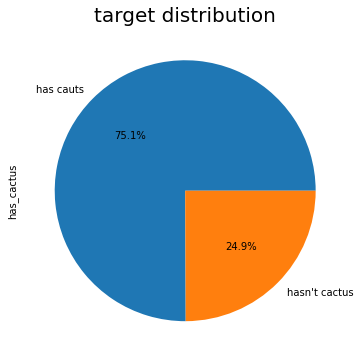

In [10]:
# 타겟 분포
ax = plt.subplot()
ax.figure.set_size_inches(6,6)
ax.set_title('target distribution',size=20)
labels['has_cactus'].value_counts().plot.pie(labels=['has cauts','hasn\'t cactus'], autopct='%.1f%%')
plt.show()

# 훈련 검증 데이터 분리

In [11]:
train, valid = train_test_split(labels,
                                test_size = 0.1, # 컴퓨터 자원이 부족해 원래 데이터의 10%만 사용
                                stratify = labels['has_cactus'],
                                random_state=42)
# train:valid = 9:1
train, valid = train_test_split(valid.reset_index(drop=True),
                                test_size = 0.1,
                                stratify = valid['has_cactus'],
                                random_state=42)

train.shape, valid.shape

((1575, 2), (175, 2))

# 데이터셋 클래스 정의

파이토치로 신경망 모델을 구축하려면 데이터셋도 일정한 형식에 맞게 정의해줘야 한다.

In [12]:
import cv2 # OpenCV 라이브러리
from torch.utils.data import Dataset
#plt.imshow(cv2.imread(path+'train/'+train.id[0]))

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() #상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)

    # 인덱스에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx,0]                  # 이미지 ID
        img_path = self.img_dir + img_id              # 이미지 파일 경로
        image = cv2.imread(img_path)                  # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# 이미지 색상 보정
        label = self.df.iloc[idx,1]                   # 이미지 레이블
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label


파이토치 모델로 이미지를 다루려면 이미지 데이터를 텐서 타입으로 바꿔야한다.

In [13]:
from torchvision import transforms

transform = transforms.ToTensor()

파이토치로 이미지를 처리할 때는 형상이 (채널수, 가로 픽셀 수 세로 픽셀 수) 순서여야 한다.

In [14]:
dataset_train = ImageDataset(df=train, img_dir=path+'train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir=path+'train/', transform=transform)

In [15]:
dataset_train

#데이터 로더 생성

지정한 배치 크기만큼씩 데이터를 불러오는 객체

In [16]:
from torch.utils.data import DataLoader

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

# 베이스라인 모델

## 시드값 고정

In [17]:
import torch
import random
import numpy as np
import os

# 시드값 고정
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)                          # 파이썬 난수 
np.random.seed(seed)                       # 넘파이 난수
torch.manual_seed(seed)                    # 파이토치 난수 CPU 사용시
torch.cuda.manual_seed(seed)               # 파이토치 난수 GPU 사용시
torch.cuda.manual_seed_all(seed)           # 파이토치 난수 멀티 GPU 사용시
torch.backends.cudnn.deterministic = True  # 확정적 연산 사용
torch.backends.cudnn.benchmark = False     # 벤치마크 기능 해제
torch.backends.cudnn.enalbed = False       # cudnn 사용 해제

In [18]:
# 연산에 이용할 장비 할당
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## 모델 생성

In [19]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

In [20]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        #첫 번째 합성곱 계층
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, padding=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2)        
        self.avg_pool = nn.AvgPool2d(kernel_size=2)        
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)

    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4) #평탄화
        x = self.fc(x)
        return x

In [21]:
# 해당 모델을 GPU에 저장
model = Model().to(device)
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

## 손실 함수 설정

In [22]:
criterion = nn.CrossEntropyLoss()

## 옵티마이저 설정

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## 학습

In [24]:
epochs = 10
# 데이터 1/10사용해서 4분
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화

    # 반복 횟수 만큼 반복
    for images, labels in loader_train:
        images = images.to(device)
        labels = labels.to(device)

        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(images)

        # 손실함수
        loss = criterion(outputs, labels)

        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item()
        loss.backward()

        # 가중치 갱신
        optimizer.step()

    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭 [1/10] - 손실값: 0.5887
에폭 [2/10] - 손실값: 0.5502
에폭 [3/10] - 손실값: 0.5420
에폭 [4/10] - 손실값: 0.5348
에폭 [5/10] - 손실값: 0.5336
에폭 [6/10] - 손실값: 0.5178
에폭 [7/10] - 손실값: 0.5076
에폭 [8/10] - 손실값: 0.4947
에폭 [9/10] - 손실값: 0.4742
에폭 [10/10] - 손실값: 0.4533


In [31]:
true_list = []
preds_list = []

# 기울기 ㅖ산 비활성화
model.eval()

with torch.no_grad():
    for images, lables in loader_valid:
        # 이미지 레이블 데이터 미니배치 장비에 할당
        images = images.to(device)
        labels = lables.to(device)

        # 순전파 이미지 데이터를 신경망 모델의 입력갑스로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측확률
        true = labels.cpu() # 실젯값

        # 예측 확률과 실젯값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)

# 검증 데이터 roc auc 점수 계산
print(roc_auc_score(true_list, preds_list))

0.9524635669673838


# 예측 및 결과제출

In [51]:
dataset_test.__len__()

4000

In [36]:
dataset_test = ImageDataset(df=sub, img_dir=path+'test/', transform=transform)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

In [52]:
# 모델을 평가상태로 설정
model.eval()

# 타겟 예측값 저장용 리스트 초기화
preds = []

# 기울기 계산 비활성화 (검증, 테스트 시에는 역전파를 사용하지 않기 때문)
with torch.no_grad():
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)

        # 순전파 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타겟값이 1인 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:,1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

# 결과 제출

In [53]:
sub['has_cactus'] = preds
sub.to_csv('sub.csv', index=False)

# 성능 개선

1. 다양한 이미지 변환 수행
2. 더 깊은 CNN 모델
3. 더 뛰어난 옵티마이저 사용
4. 훈련 시 에폭 수 증가